In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# python
class Node(object):
    """
    Base class for nodes in the network.

    Arguments:

        `inbound_nodes`: A list of nodes with edges into this node.
    """
    def __init__(self, inbound_nodes=[]):
        """
        Node's constructor (runs when the object is instantiated). Sets
        properties that all nodes need.
        """
        # A list of nodes with edges into this node.
        self.inbound_nodes = inbound_nodes
        # The eventual value of this node. Set by running
        # the forward() method.
        self.value = None
        # A list of nodes that this node outputs to.
        self.outbound_nodes = []
        # New property! Keys are the inputs to this node and
        # their values are the partials of this node with
        # respect to that input.
        self.gradients = {}

        # Sets this node as an outbound node for all of
        # this node's inputs.
        for node in inbound_nodes:
            node.outbound_nodes.append(self)

    def forward(self):
        """
        Every node that uses this class as a base class will
        need to define its own `forward` method.
        """
        raise NotImplementedError

    def backward(self):
        """
        Every node that uses this class as a base class will
        need to define its own `backward` method.
        """
        raise NotImplementedError


class Input(Node):
    """
    A generic input into the network.
    """
    def __init__(self):
        Node.__init__(self)

    def forward(self):
        pass

    def backward(self):
        self.gradients = {self: 0}
        for n in self.outbound_nodes:
            self.gradients[self] += n.gradients[self]

class Linear(Node):
    """
    Represents a node that performs a linear transform.
    """
    def __init__(self, X, W, b):
        Node.__init__(self, [X, W, b])

    def forward(self):
        """
        Performs the math behind a linear transform.
        """
        X = self.inbound_nodes[0].value
        W = self.inbound_nodes[1].value
        b = self.inbound_nodes[2].value
        self.value = np.dot(X, W) + b

    def backward(self):
        """
        Calculates the gradient based on the output values.
        """
        self.gradients = {n: np.zeros_like(n.value) for n in self.inbound_nodes}
        for n in self.outbound_nodes:
            grad_cost = n.gradients[self]
            self.gradients[self.inbound_nodes[0]] += np.dot(grad_cost, self.inbound_nodes[1].value.T)
            self.gradients[self.inbound_nodes[1]] += np.dot(self.inbound_nodes[0].value.T, grad_cost)
            self.gradients[self.inbound_nodes[2]] += np.sum(grad_cost, axis=0, keepdims=False)


class Sigmoid(Node):
    """
    Represents a node that performs the sigmoid activation function.
    """
    def __init__(self, node):
        Node.__init__(self, [node])

    def _sigmoid(self, x):
        """
        This method is separate from `forward` because it
        will be used with `backward` as well.

        `x`: A numpy array-like object.
        """
        return 1. / (1. + np.exp(-x))

    def forward(self):
        """
        Perform the sigmoid function and set the value.
        """
        input_value = self.inbound_nodes[0].value
        self.value = self._sigmoid(input_value)

    def backward(self):
        """
        Calculates the gradient using the derivative of
        the sigmoid function.
        """
        self.gradients = {n: np.zeros_like(n.value) for n in self.inbound_nodes}
        for n in self.outbound_nodes:
            grad_cost = n.gradients[self]
            sigmoid = self.value
            self.gradients[self.inbound_nodes[0]] += sigmoid * (1 - sigmoid) * grad_cost


class MSE(Node):
    def __init__(self, y, a):
        """
        The mean squared error cost function.
        Should be used as the last node for a network.
        """
        Node.__init__(self, [y, a])

    def forward(self):
        """
        Calculates the mean squared error.
        """
        y = self.inbound_nodes[0].value.reshape(-1, 1)
        a = self.inbound_nodes[1].value.reshape(-1, 1)

        self.m = self.inbound_nodes[0].value.shape[0]
        self.diff = y - a
        self.value = np.mean(self.diff**2)

    def backward(self):
        """
        Calculates the gradient of the cost.
        """
        self.gradients[self.inbound_nodes[0]] = (2 / self.m) * self.diff
        self.gradients[self.inbound_nodes[1]] = (-2 / self.m) * self.diff
        
  

In [3]:
# python
def topological_sort(feed_dict):
    """
    Sort the nodes in topological order using Kahn's Algorithm.

    `feed_dict`: A dictionary where the key is a `Input` Node and the value is the respective value feed to that Node.

    Returns a list of sorted nodes.
    """
    input_nodes = [n for n in feed_dict.keys()]
    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outbound_nodes:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()
        if isinstance(n, Input):
            n.value = feed_dict[n]

        L.append(n)
        for m in n.outbound_nodes:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            if len(G[m]['in']) == 0:
                S.add(m)
    return L





In [4]:
def forward_and_backward(graph):
    """
    Performs a forward pass and a backward pass through a list of sorted Nodes.

    Arguments:

        `graph`: The result of calling `topological_sort`.
    """
    for n in graph:
        n.forward()

    for n in graph[::-1]:
        n.backward()



In [5]:
def sgd_update(trainables, learning_rate=1e-2):
    """
    Updates the value of each trainable with SGD.

    Arguments:

        `trainables`: A list of `Input` Nodes representing weights/biases.
        `learning_rate`: The learning rate.
    """
    for t in trainables:
        t.value = t.value - learning_rate * t.gradients[t]

## 构建鸢尾花分类数据集

In [6]:
from sklearn.utils import resample
from sklearn import datasets

%matplotlib inline

data = datasets.load_iris()
X_ = data.data
y_ = data.target
y_[y_==2] = 1 # 0 for virginica, 1 for not virginica
print(X_.shape, y_.shape)

(150, 4) (150,)


## 搭建深度神经网络模型

可以理解为两层逻辑斯蒂回归串联，输入层4个特征，输出层2个预测（不是 virginica 的可能性），中间层这里设置为3。

In [7]:
np.random.seed(42)
n_features = X_.shape[1]
n_class = 1
n_hidden = 3


X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
t1 = Sigmoid(l2)
cost = MSE(y, t1)


In [8]:
# 随机初始化参数值
W1_0 = np.random.random(X_.shape[1]*n_hidden).reshape([X_.shape[1], n_hidden])
W2_0 = np.random.random(n_hidden*n_class).reshape([n_hidden, n_class])
b1_0 = np.random.random(n_hidden)
b2_0 = np.random.random(n_class)

# 将输入值带入算子
feed_dict = {
    X: X_,   y: y_,
    W1: W1_0, b1: b1_0,
    W2: W2_0, b2: b2_0
}

# 训练参数
# 这里训练100轮（eprochs），每轮抽4个样本（batch_size）训练150/4次（steps_per_eproch）,学习率 0.1
epochs = 100
m = X_.shape[0]
batch_size = 4
steps_per_epoch = m // batch_size
lr = 0.1

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

l_Mat_W1 = [W1_0]
l_Mat_W2 = [W2_0]

l_loss = []
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)
        X.value = X_batch
        y.value = y_batch
        
        forward_and_backward(graph)
        sgd_update(trainables, lr)
        loss += graph[-1].value
    
    l_loss.append(loss)
    if i % 10 == 9:
        print("Eproch %d, Loss = %1.5f" % (i, loss))
    

Eproch 9, Loss = 8.79485
Eproch 19, Loss = 4.76923
Eproch 29, Loss = 1.59270
Eproch 39, Loss = 0.86570
Eproch 49, Loss = 0.56411
Eproch 59, Loss = 0.40082
Eproch 69, Loss = 0.30961
Eproch 79, Loss = 0.25704
Eproch 89, Loss = 0.20941
Eproch 99, Loss = 0.17813


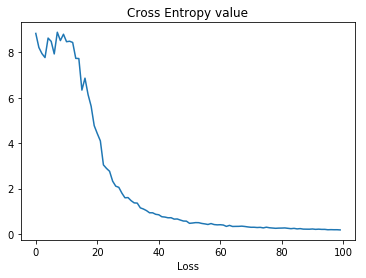

In [9]:
plt.plot(l_loss)
plt.title("Cross Entropy value")
plt.xlabel("Eproch")
plt.xlabel("Loss")

# 用模型预测所有数据

In [10]:
X.value = X_
y.value = y_
for n in graph:
    n.forward()

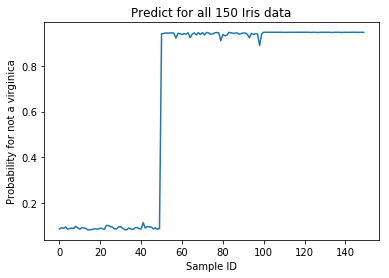

In [11]:
plt.plot(graph[-2].value.ravel())
plt.title("Predict for all 150 Iris data")
plt.xlabel("Sample ID")
plt.ylabel("Probability for not a virginica")